In [1]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import get_dfs, print_confusion_matrix, plot_feature_importances, year_to_decade
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, multilabel_confusion_matrix
from pprint import pprint
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier

data_df, numerical_df, test_df = get_dfs()

# function to easily print and plot metrics in one line for all models


def classification_metrics(X, y, model, y_test, y_pred):
    classification_report(y_test, y_pred)
    print_confusion_matrix(y_test, y_pred, y)
    plot_feature_importances(model, X)

/Users/emilvinther/ITU/3_semester/data mining/DataMining/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['track_album_release_date'] = pd.to_datetime(
/Users/emilvinther/ITU/3_semester/data mining/DataMining/utils.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['track_album_release_date'].dt.year


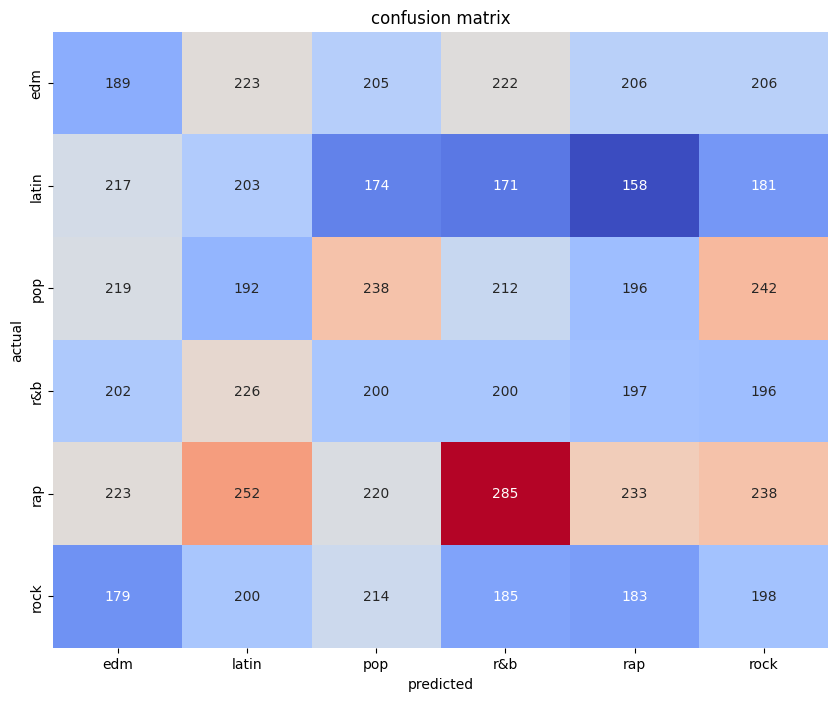

In [2]:
# BASELINE MODEL FOR COMPARISON
X = numerical_df
y = data_df['playlist_genre']
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=0.33, random_state=42)
dummy = DummyClassifier(strategy='uniform')


dummy.fit(X_train, y_train)

y_pred_majority = dummy.predict(X_validation)


print_confusion_matrix(y_validation, y_pred_majority, y)

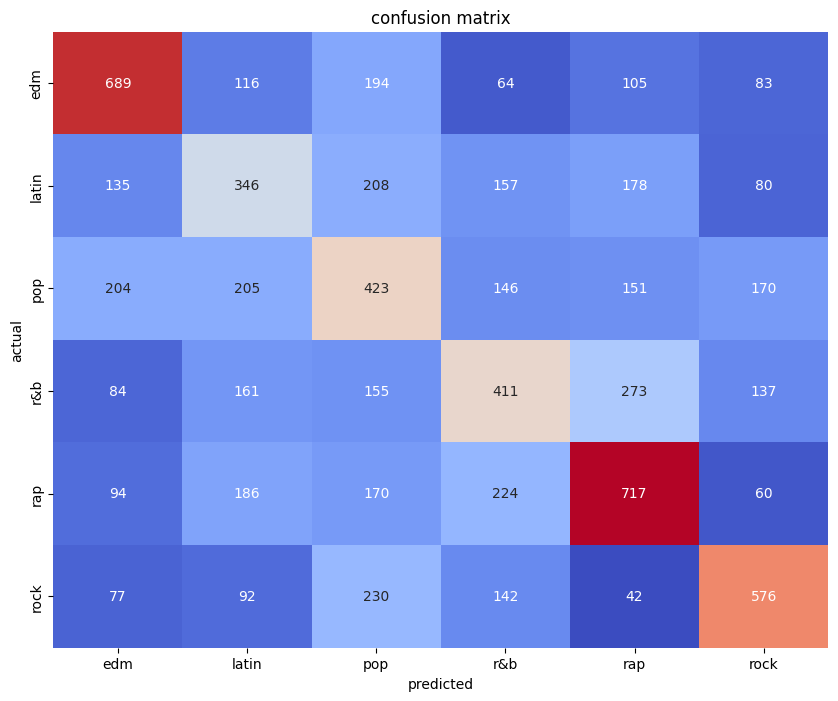

<Figure size 1000x800 with 0 Axes>

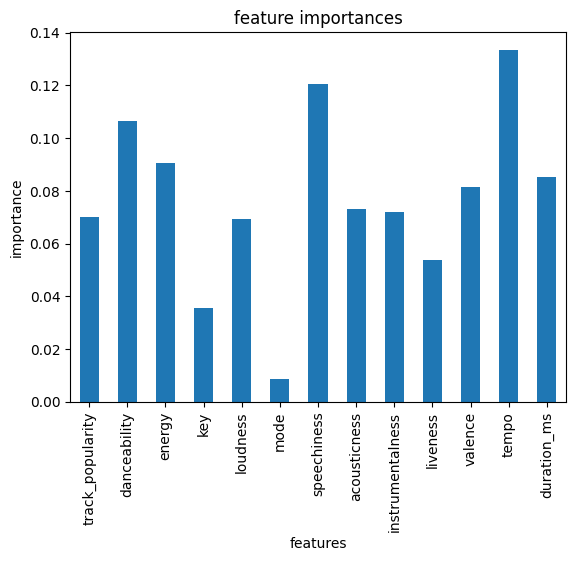

In [3]:
# TRYING TO PREDICT GENRE BASED ON MUSICAL FEATURES
X = numerical_df
y = data_df['playlist_genre']
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=0.33, random_state=42)

model = DecisionTreeClassifier(criterion='gini', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_validation)

classification_metrics(X, y, model, y_validation, y_pred)



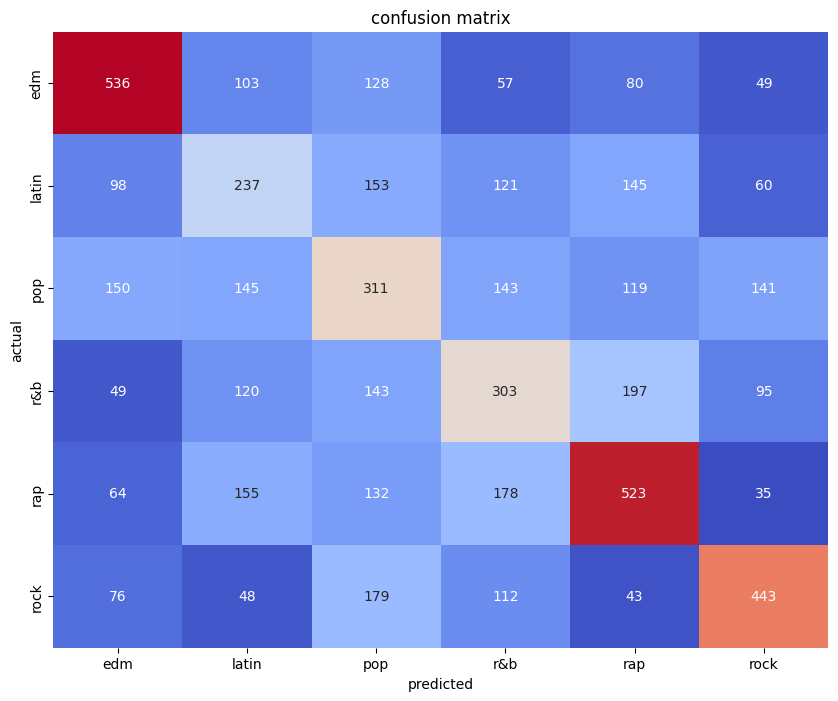

<Figure size 1000x800 with 0 Axes>

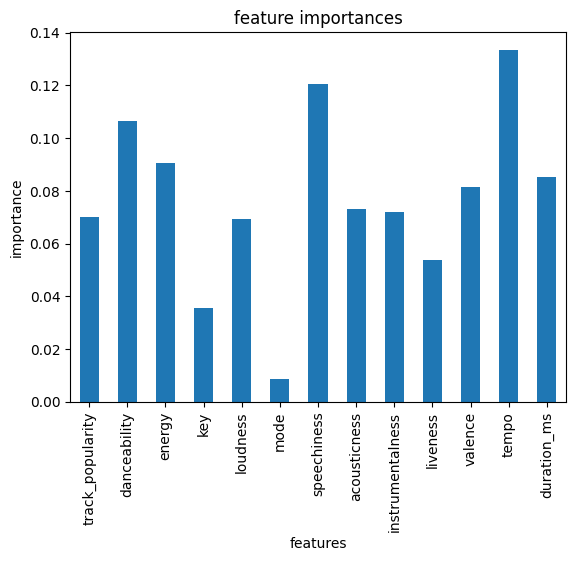

In [4]:
# FINAL PREDICTION USING TEST SET
# creating test data
X_test = test_df[X.columns]
y_test = test_df['playlist_genre']
# final prediction
y_pred = model.predict(X_test)

classification_metrics(X, y, model, y_test, y_pred)

{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 8, 'splitter': 'best'}


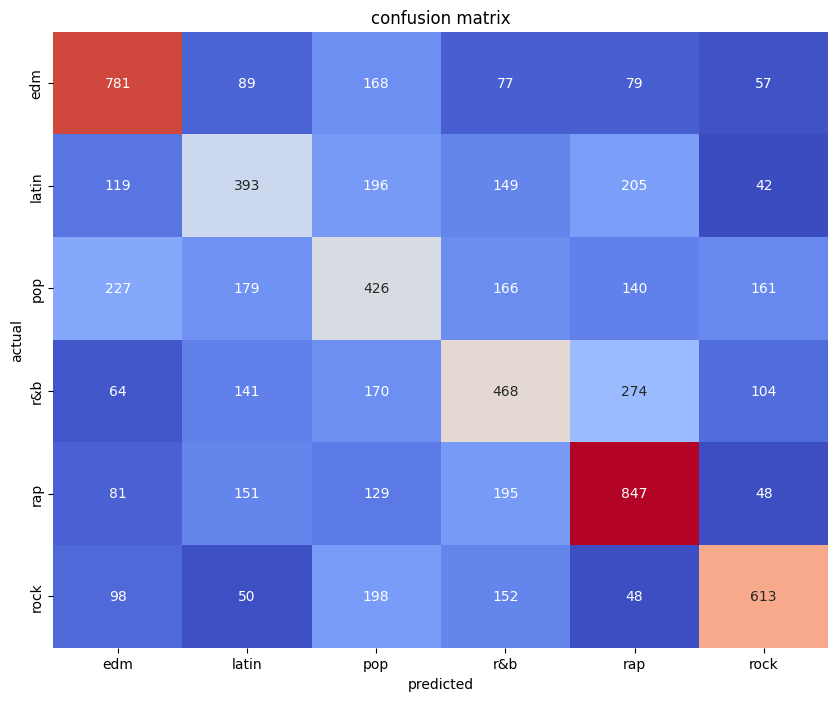

<Figure size 1000x800 with 0 Axes>

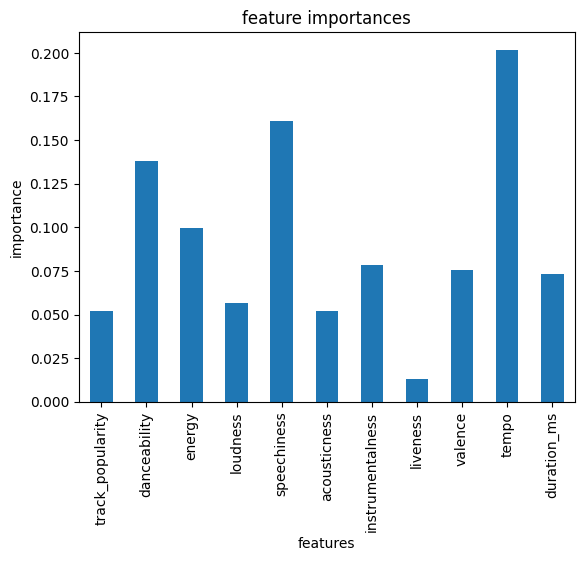

In [5]:
# IMPROVED VERSION OF DECISION TREE INCLUDING GRID SEARCH, DROPPING "MODE" AND "KEY"
#  dropping 'mode' and 'key' since they do not make any difference in the result
X = numerical_df.drop(['mode', 'key'], axis=1)
y = data_df['playlist_genre']
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=0.33, random_state=42)

model = DecisionTreeClassifier(random_state=42)
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'min_samples_split': [2, 4, 8],
    'max_depth': [5, 10, 20, 30]
}

grid_search = GridSearchCV(model, param_grid, scoring='accuracy')
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_validation)
print(grid_search.best_params_)

classification_metrics(X, y, grid_search.best_estimator_, y_validation, y_pred)



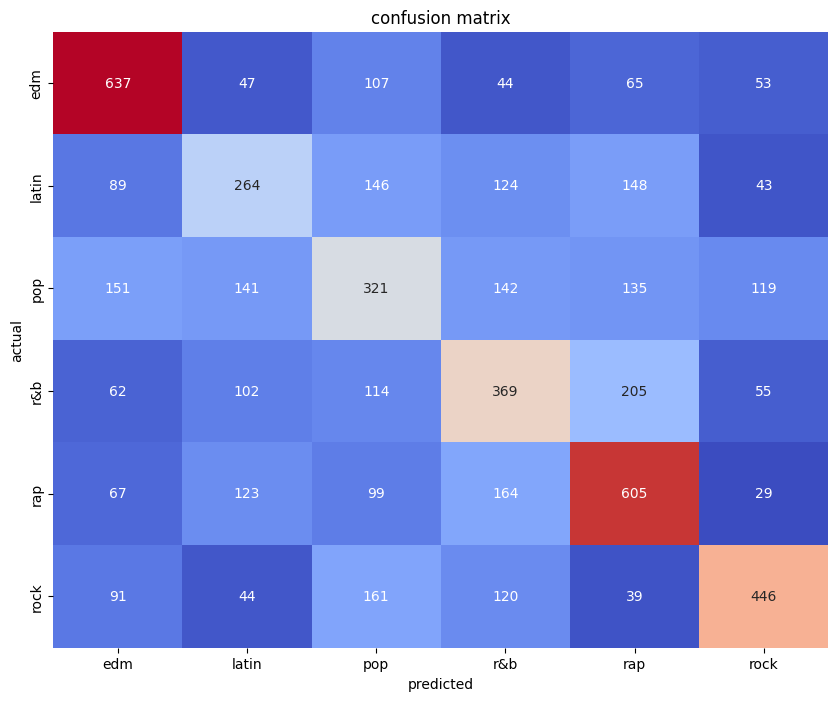

<Figure size 1000x800 with 0 Axes>

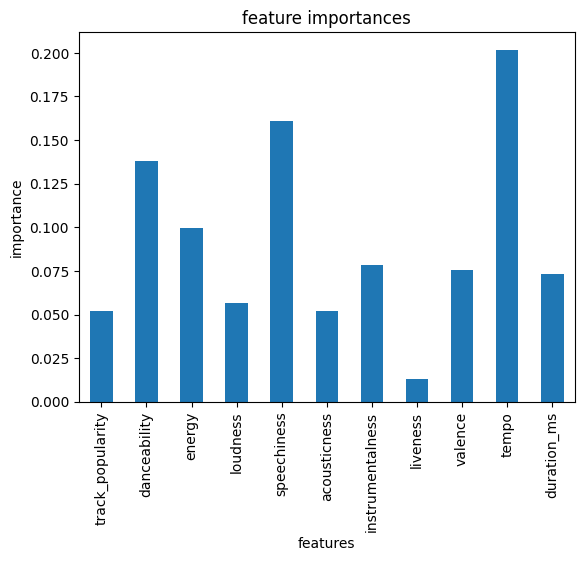

In [6]:
# FINAL PREDICTION USING TEST SET
# creating test data
X_test = test_df[X.columns]
y_test = test_df['playlist_genre']
# final prediction
y_pred = grid_search.predict(X_test)
classification_metrics(X, y, grid_search.best_estimator_, y_test, y_pred)

              precision    recall  f1-score   support

         edm       0.33      0.39      0.36      1251
       latin       0.42      0.34      0.38      1104
         pop       0.29      0.30      0.29      1299
         r&b       0.41      0.26      0.32      1221
         rap       0.34      0.50      0.40      1451
        rock       0.50      0.38      0.43      1159

    accuracy                           0.37      7485
   macro avg       0.38      0.36      0.36      7485
weighted avg       0.38      0.37      0.36      7485



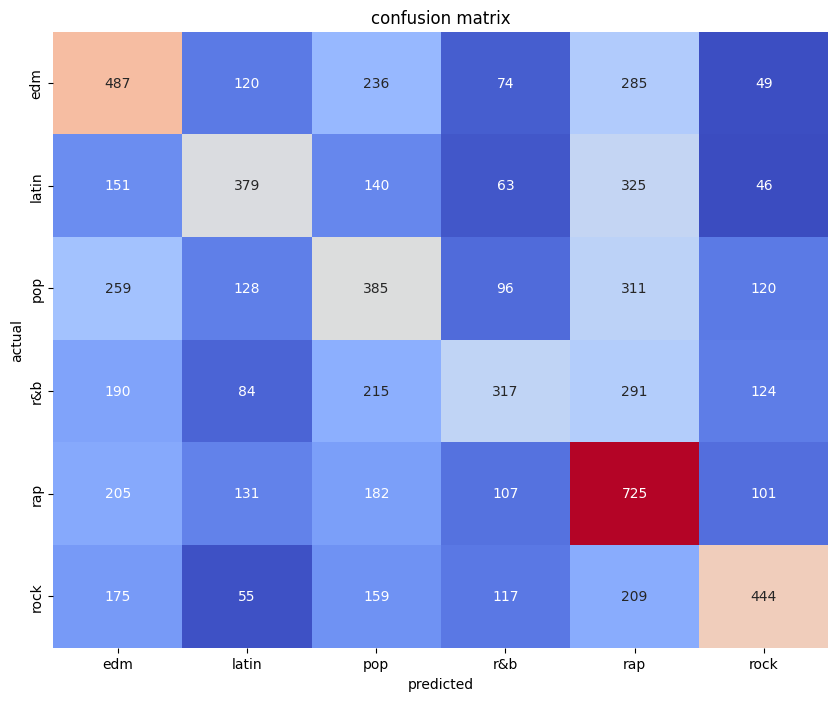

In [7]:
# PREDICTING PlAYLIST GENRE BASED ON track_name AND track_album_name


data_df['text'] = data_df['track_name'] + ' ' + data_df['track_album_name']
X = data_df['text']
y = data_df['playlist_genre']
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=0.33, random_state=42)


pipe = Pipeline([
    # ('count', CountVectorizer()),

    ('tfidf', TfidfVectorizer(ngram_range=(1, 6))),
    # ('naive_bayes', MultinomialNB()),
    # ('svc', SVC()),
    # ('lr', LogisticRegression()),
    ('dt', DecisionTreeClassifier(criterion='gini', random_state=42)),
    # ('rf', RandomForestClassifier()),
    # ('knn', KNeighborsClassifier(n_neighbors=300)),
    # ('gb', GradientBoostingClassifier()),
    # ('mlp', MLPClassifier())
])

pipe.fit(X_train, y_train)


ypred = pipe.predict(X_validation)
print(classification_report(y_validation, ypred))
# ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)
print_confusion_matrix(y_validation, ypred, y)


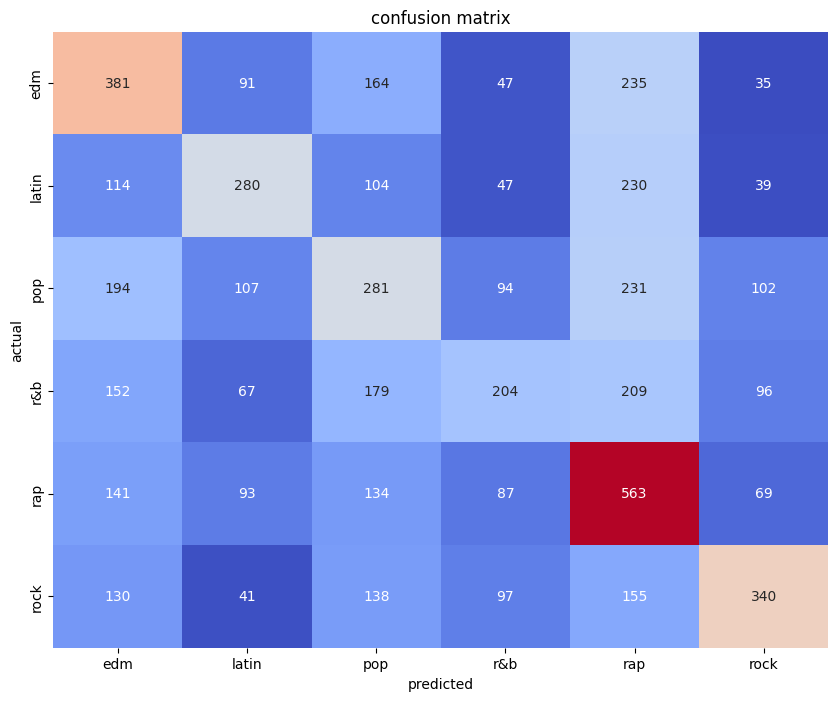

In [8]:
# FINAL PREDICTION USING TEST SET
test_df['text'] = test_df['track_name'] + ' ' + test_df['track_album_name']
# creating test data
X_test = test_df['text']

y_test = test_df['playlist_genre']
# final prediction
y_pred = pipe.predict(X_test)

print_confusion_matrix(y_test, y_pred, y)

              precision    recall  f1-score   support

         edm       0.56      0.59      0.57      1251
       latin       0.34      0.33      0.33      1104
         pop       0.32      0.33      0.33      1299
         r&b       0.38      0.37      0.37      1221
         rap       0.51      0.52      0.51      1451
        rock       0.56      0.55      0.55      1159

    accuracy                           0.45      7485
   macro avg       0.45      0.45      0.45      7485
weighted avg       0.45      0.45      0.45      7485



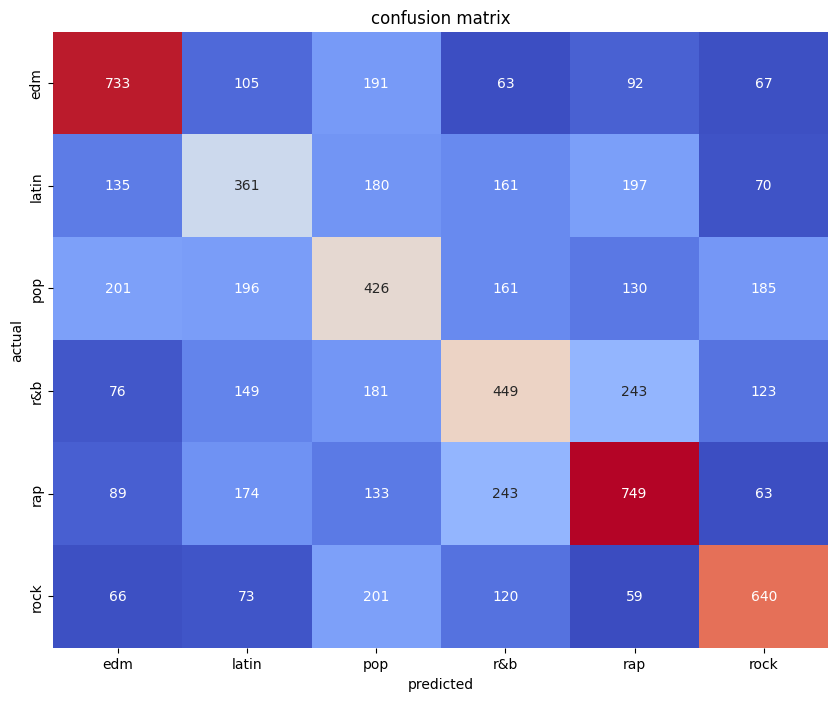

In [9]:
# COMBINING TEXT AND MUSICAL FEATURES FOR GENRE PREDICTION


X = numerical_df
X['text'] = data_df['track_name'] + ' ' + data_df['track_album_name']
y = data_df['playlist_genre']
# preprocessing steps for different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(ngram_range=(1, 6)), 'text'),
        # using numeric columns only
        ('scaler', StandardScaler(), X.select_dtypes(include='number').columns)
    ]
)
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('dt', DecisionTreeClassifier(criterion='gini', random_state=42))
])
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=0.33, random_state=42)


pipe.fit(X_train, y_train)
ypred = pipe.predict(X_validation)
print(classification_report(y_validation, ypred))
# ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)
print_confusion_matrix(y_validation, ypred, y)

<ipython-input-10-f33f40266d9c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['text'] = test_df['track_name'] + ' ' + test_df['track_album_name']


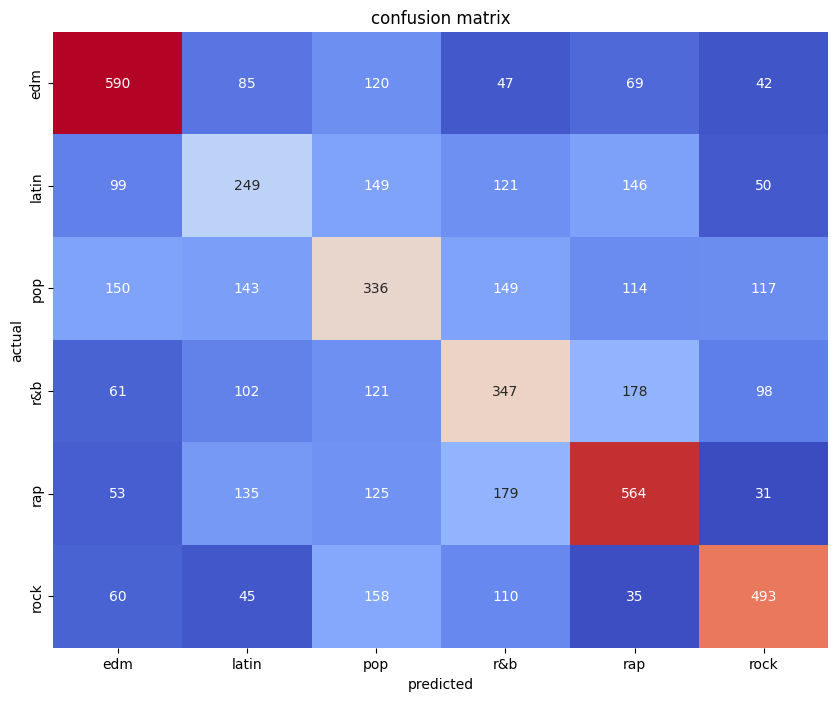

In [10]:
# FINAL PREDICTION USING TEST SET

X_test = test_df[numerical_df.columns]

X_test['text'] = test_df['track_name'] + ' ' + test_df['track_album_name']

# creating test data

y_test = test_df['playlist_genre']
# final prediction
y_pred = pipe.predict(X_test)

print_confusion_matrix(y_test, y_pred, y)


########### models not included in report #######

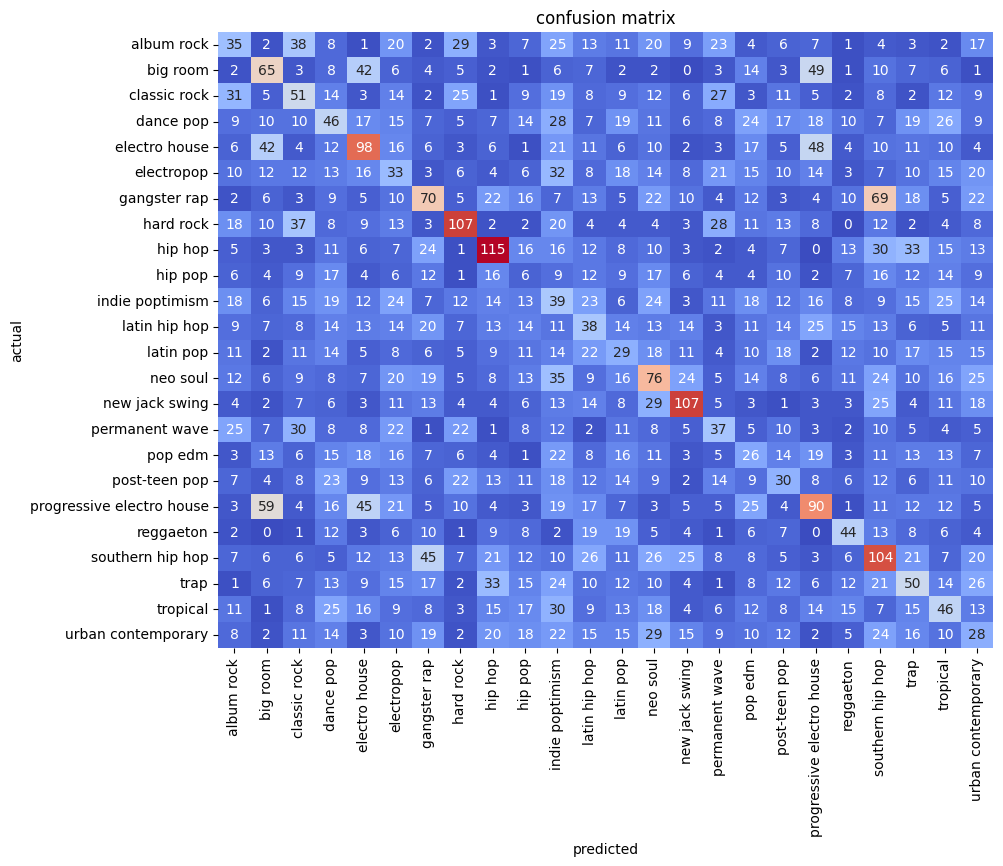

<Figure size 1000x800 with 0 Axes>

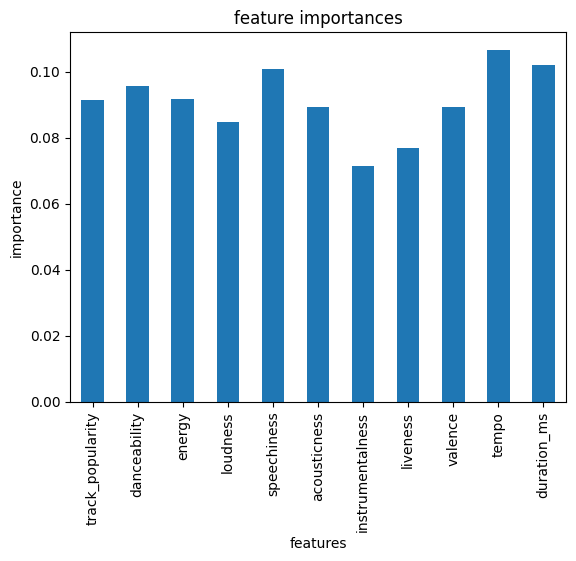

In [11]:
# PREDICTING SUBGENRE BASED ON MUSICAL FEATURES
X = numerical_df.drop(['key', 'mode'], axis=1)
y = data_df['playlist_subgenre']
X = X.drop('text', axis=1)

X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=0.33, random_state=42)

model = DecisionTreeClassifier(criterion='gini', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_validation)
classification_metrics(X, y, model, y_validation, y_pred)

/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                           precision    recall  f1-score   support

               album rock       0.56      0.38      0.45       290
                 big room       0.31      0.36      0.33       249
             classic rock       0.35      0.39      0.37       288
                dance pop       0.23      0.32      0.27       349
            electro house       0.33      0.34      0.33       356
               electropop       0.32      0.13      0.19       310
             gangster rap       0.36      0.38      0.37       352
                hard rock       0.42      0.59      0.49       330
                  hip hop       0.40      0.48      0.44       357
                  hip pop       0.33      0.02      0.04       212
          indie poptimism       0.17      0.23      0.19       363
            latin hip hop       0.26      0.17      0.21       312
                latin pop       0.32      0.34      0.33       279
                 neo soul       0.37      0.50      0.43     

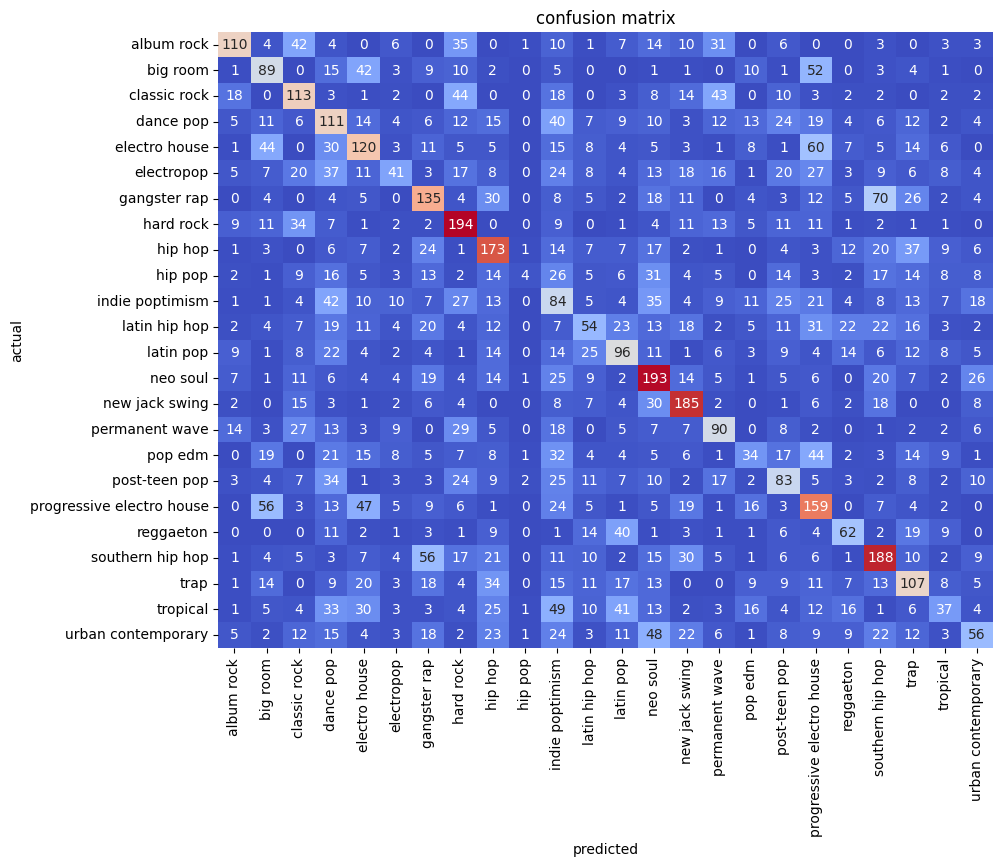

In [12]:
# PREDICTING SUBGENRE BY COMBINED TEXT AND MUSICAL FEATURES
X = numerical_df
X['text'] = data_df['track_name'] + ' ' + data_df['track_album_name']
y = data_df['playlist_subgenre']
# preprocessing steps for different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(ngram_range=(1, 6)), 'text'),
        # using numeric columns only
        ('scaler', StandardScaler(), X.select_dtypes(include='number').columns)
    ]
)
pipe = Pipeline([
    ('preprocessor', preprocessor),
    # ('poly_features', PolynomialFeatures()),
    ('regression', LogisticRegression())
])
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=0.33, random_state=42)


pipe.fit(X_train, y_train)
ypred = pipe.predict(X_validation)
print(classification_report(y_validation, ypred))
# ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)
print_confusion_matrix(y_validation, ypred, y)


#################### ADDITIONAL MODELS ##################

In [15]:
# TRYING TO PREDICT TRACK POPULARITY BASED ON MUSICAL FEATURES
X = numerical_df.drop(['track_popularity','text'], axis=1)
y = data_df['track_popularity']
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=0.33, random_state=42)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures()),
    ('regression', Ridge())
])
param_grid = {
    'poly_features__degree': [1, 2, 3,],
    'regression__alpha': [0.1, 0.5, 1, 10,]
}

grid_search = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_validation)

mae = mean_absolute_error(y_validation, y_pred)
mse = mean_squared_error(y_validation, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_validation, y_pred)

metrics = {"mae": mae, "mse": mse, "rmse": rmse, "r2": r2}
# Horrible performance
pprint(metrics)
print(grid_search.best_params_)

{'mae': 18.987821357598392,
 'mse': 519.3363472699323,
 'r2': 0.06180559479711312,
 'rmse': 22.788952307421514}
{'poly_features__degree': 2, 'regression__alpha': 10}


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


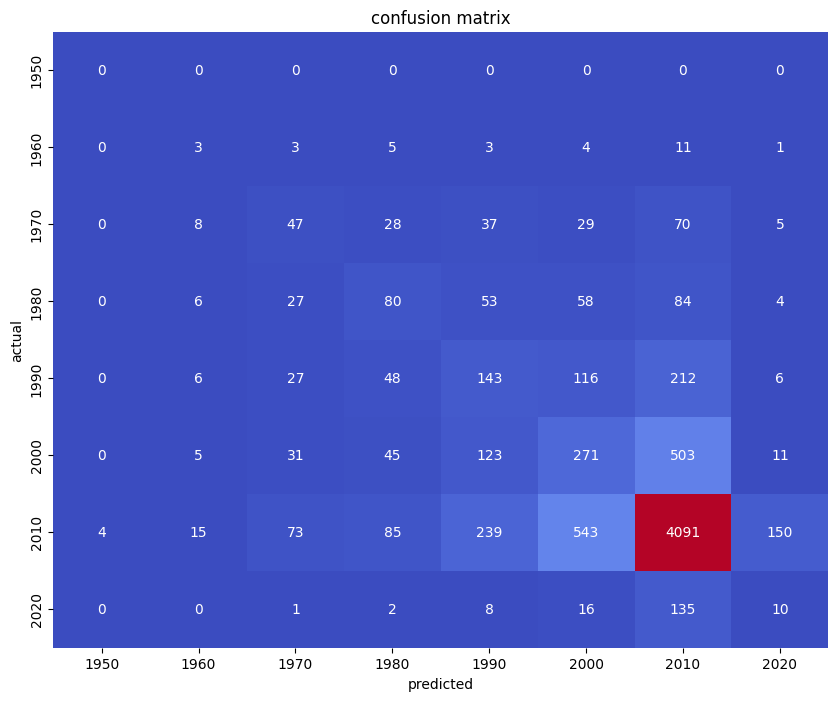

<Figure size 1000x800 with 0 Axes>

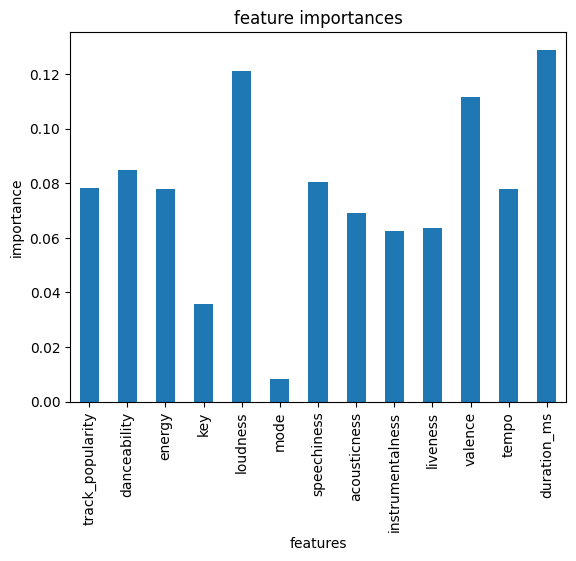

In [16]:
df = year_to_decade(data_df)
y = df['decade']


# Apparently very little information is needed for classifying songs based on year
# X = X[['speechiness', 'danceability']]
X = numerical_df.drop('text', axis=1)
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=0.33, random_state=42)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_validation)

classification_metrics(X, y, model, y_validation, y_pred)